In [155]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans


df = pd.read_csv("UsArrests.csv")
df.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


This data set contains the number of arrests per 100,000 residents for Murder, Assault, Rape and the percantage of the population living in an urban area. There is data for all 50 US states and it is from 1973

In [156]:
# set the index to the city Column
df.set_index('City', inplace=True)

pd.set_option('display.float_format', lambda x: '%.2f' % x) 
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.07
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.18
max,17.40,337.00,91.00,46.00


In [157]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


There is no missing data in the data set so we do not need to make any changes to our dataset

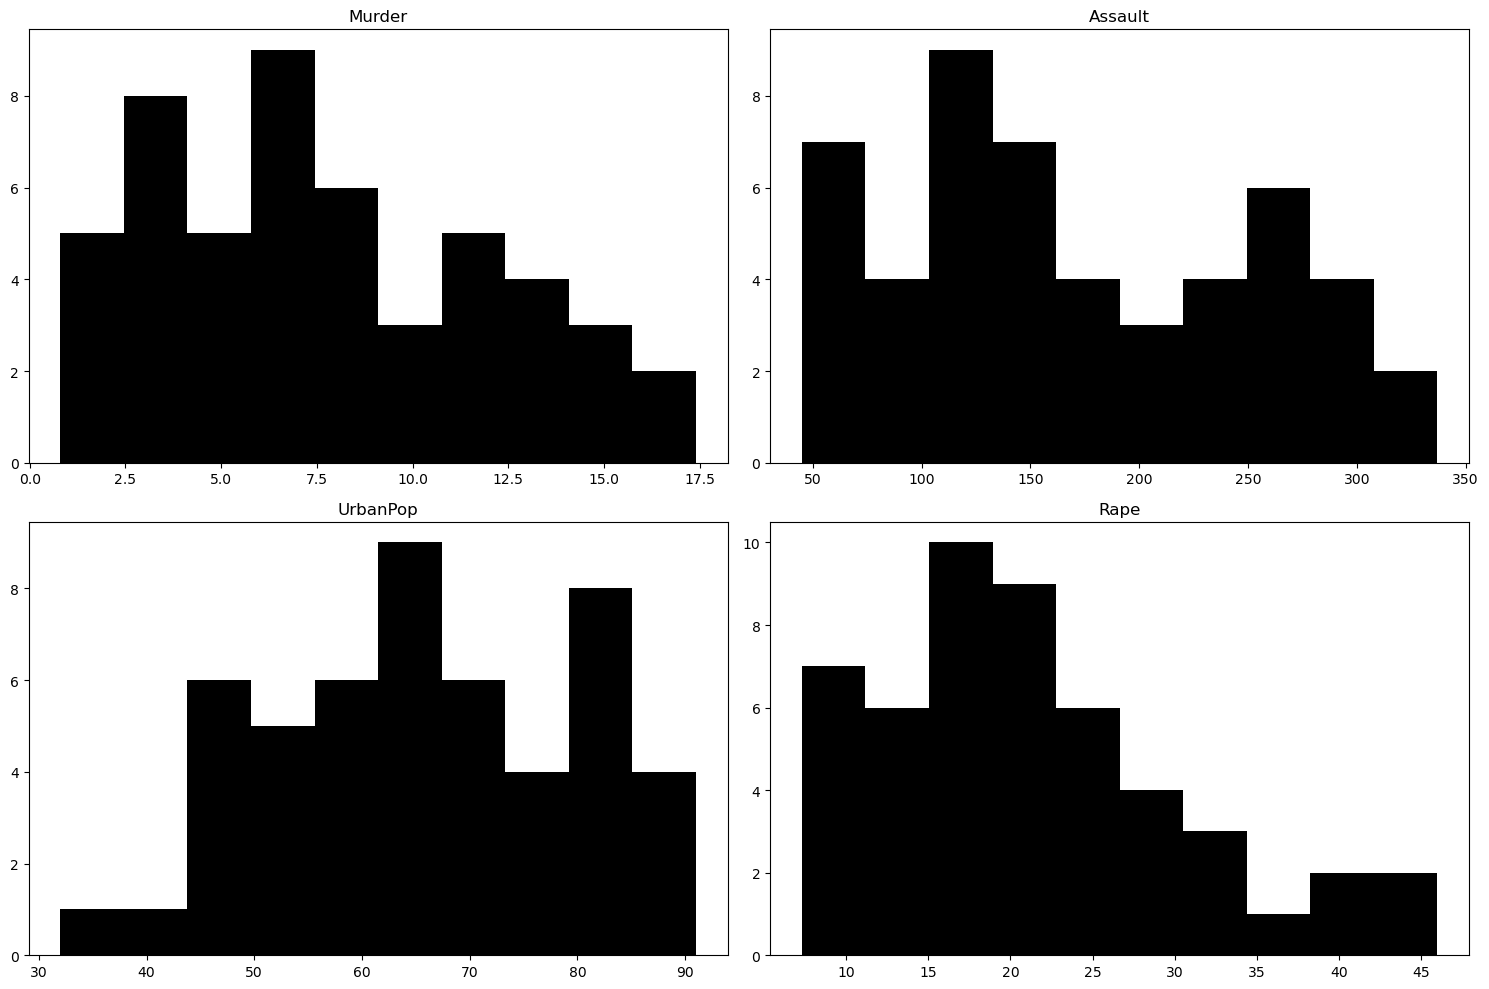

In [176]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()

Here we can see that UrbanPop is close to being normally distributed, whereas the other 3 features arent so it will be a good idea to apply some scaling when we start our analysis, to stop any one feature impacting the analysis disproportionately. 

C:\Users\tmand\AppData\Local\Temp\ipykernel_15712\1111530602.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)


<AxesSubplot:>

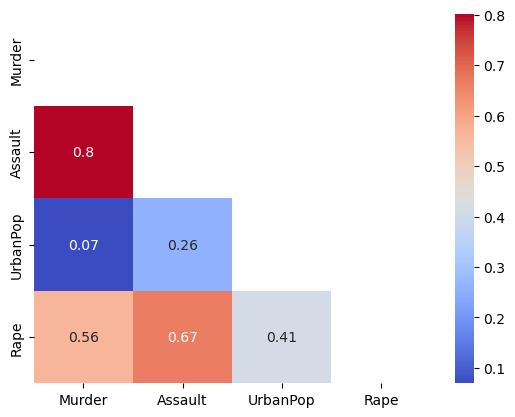

In [160]:
corr_df = df.corr()

mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm", annot = True)

Here we can see that there is a large posistive correlation between Assualt and Murder arrest, this is intuitive as Crimes that involve Assault are often very dangerous and can lead to killing someone and therefore becoming a murder. This correlation makes the data a good candidate for PCA

In [161]:
np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)
# create data frame with our principal componets we have created
df_pca = pd.DataFrame(X_trans, index=df.index)
df_pca.head()

,0,1,2,3
City,,,,
Alabama,64.80,11.45,-2.49,2.41
Alaska,92.83,17.98,20.13,-4.09
Arizona,124.07,-8.83,-1.69,-4.35
Arkansas,18.34,16.70,0.21,-0.52
California,107.42,-22.52,6.75,-2.81


Here we have our data now using the principal components we have created by using PCA. Next we will take the first 2 principal components and plot a bi plot so we can see if we can identify any features within the data.

In [162]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

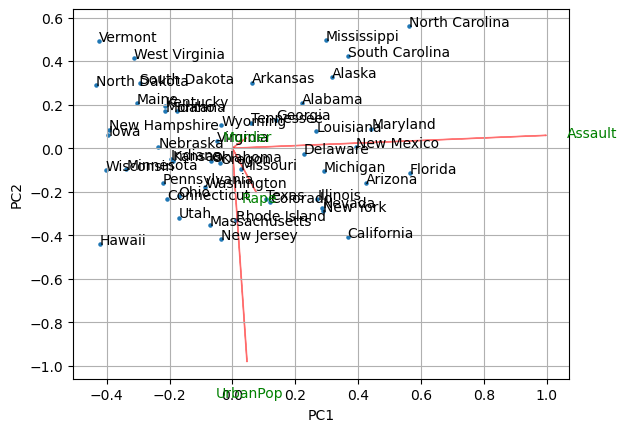

In [163]:

# Plot bi plot
labels = corr_df.columns
cities = df.index
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

Here we can see that without any scaling the data is dominated by the larger values of Assault and UrbanPop, and the Rape and Murder contributions are very hard to identify. To confirm this we can use feature importance to work out the contribution of each variable to the prinicipal component.

In [164]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )


feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


Here we can see that Assault is the main driving factor of the 1st principal component and Urban Pop is the main driving factor of the second. We now want to see if we scale the data we can get better results.

In [165]:
# Scale data
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
# Apply PCA
std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)
# Create data frame
df_std_pca = pd.DataFrame(X_std_trans, index=df.index)
df_std_pca.head()

,0,1,2,3
City,,,,
Alabama,0.986,1.133,-0.444,0.156
Alaska,1.950,1.073,2.040,-0.439
Arizona,1.763,-0.746,0.055,-0.835
Arkansas,-0.141,1.120,0.115,-0.183
California,2.524,-1.543,0.599,-0.342


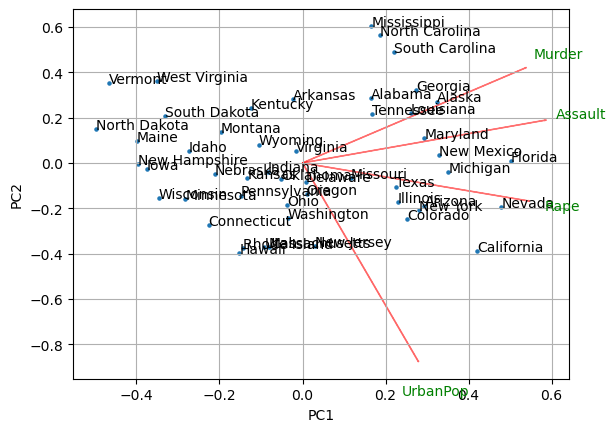

In [166]:
# Plot bi plot for scaled data
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We can now see how the Murder and Rape affects the data after performing our scaling. From looking at the bi-plot we can see a grouping of the Murder, and Assault and Rape are closest to the axis of the principal component 1, so these 3 are making the biggest contribution to the 1st principal component. Whereas the UrbanPop is closest to the vertical axis representing the 2nd principal component so it makes the biggest contribution.

We can check this by using the feature importance 

In [167]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


This backs up our assumption that Murder, Rape and Assault make up the majority of 1st principal component and UrbanPop makes up the majority of the 2nd component.

Text(0.5, 1.0, 'Scree plot')

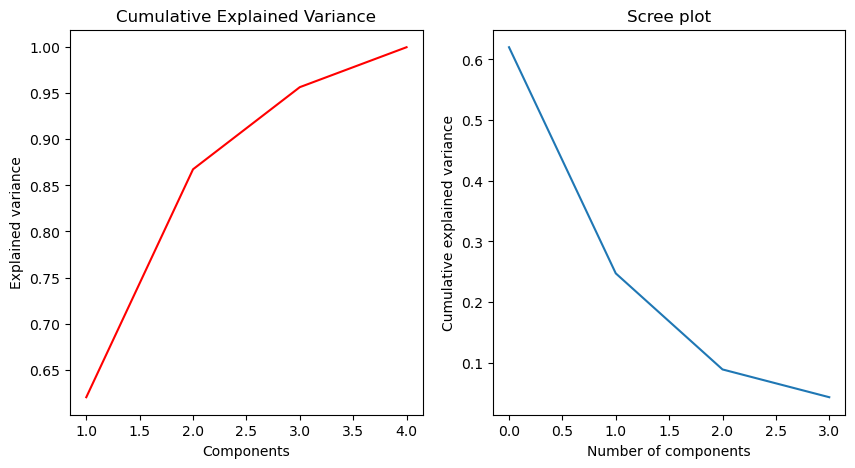

In [168]:

plt.figure(figsize=(10,5))
# Cumulative variance plot
plt.subplot(1,2,1)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

# Scree plot
plt.subplot(1,2,2)
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Scree plot")


From these graphs we can see that we can explian the majority of the variance by using only 2 components, which means we can reduce the number of variables from 4 to 2

In [169]:
# Create a data frame of just the first 2 principal components
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


Using these two components we will now apply a heirachical clusting method using 3 different methods: single, average and complete. We will compare them to see which provides the most balanced dispersion of clusters

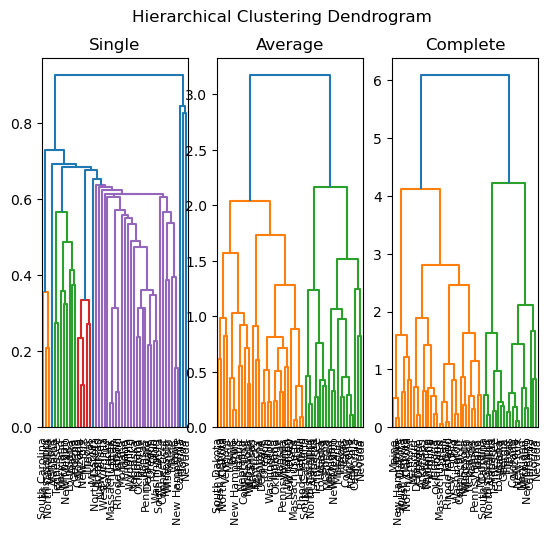

In [170]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Here we can see that the complete and average linkage methods create the most balanced dispersion of clusters so for the rest of our analysis we shall choose to use Complete as there isnt much difference between that and Average

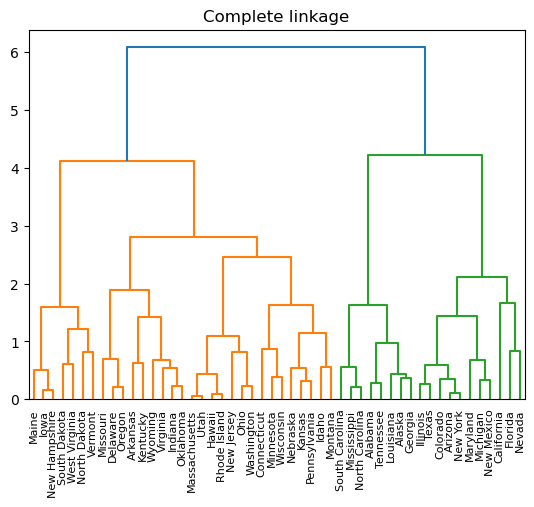

In [171]:
plt.title("Complete linkage")
ax = dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)

Here is a better look at the complete linkage method, from the dendrogram we get the biggest distance between the clusters when there are 2 clusters which are represented by the blue lines, this means by separating the data into two clusters the clusters should be more dissimilar than separating it into more clusters. From this, we can now move onto K-means clustering using a value of k=2 which we have decided from our dendrogram.

Text(0, 0.5, 'Principal Component 2')

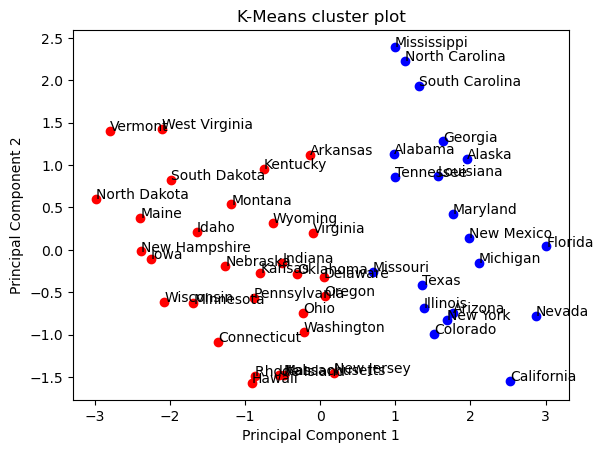

In [172]:
# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgymk'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")


Here we can see the cities seperated into the two clusters, to see the effectiveness of the clustering we can use the silhouette score to calculate the accuracy of our clusters.

In [173]:
from sklearn.metrics import accuracy_score, silhouette_score

score = round(silhouette_score(X_std_trans, cluster_labels),2)
print(f'Silhouette score is: {score}')

Silhouette score is: 0.41


The silhouette score isnt great which tells us that the data isnt clustered particullarly well, We could try increasing the number of clusters from 2 to 4 which looked like the next best value from the dendrogram

Silhouette score is: 0.34


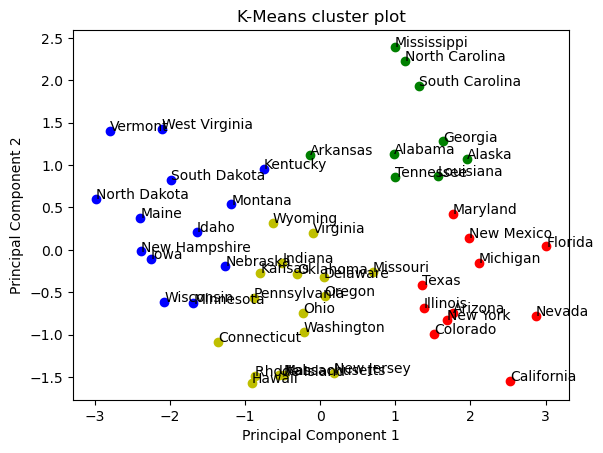

In [177]:
# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgymk'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")


score = round(silhouette_score(X_std_trans, cluster_labels),2)
print(f'Silhouette score is: {score}')

When we do this the silhouette score gets worse which shows that our best possible clustering is when we use 2 clusters. But when we use 2 clusters the cities do not group into particularly distinct clusters which implies that this data is not suited to being clustered.